<a href="https://colab.research.google.com/github/ac1147/Lifting_Tracker/blob/main/Workout_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [1]:
!pip install gspread gspread_dataframe

# Authenticate with your Google account
from google.colab import auth
auth.authenticate_user()

import gspread
from gspread_dataframe import get_as_dataframe
from google.auth import default
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from IPython.display import display, HTML

# Authorize access to Google Sheets
creds, _ = default()
gc = gspread.authorize(creds)

# **Set Up Data**

In [27]:
# Open the spreadsheet by its name
sh = gc.open("Lifting Progress")

# Select the sheet (tab) called "Master Data Base"
worksheet = sh.worksheet("Matser Data Base")

# Convert the sheet into a pandas DataFrame
df = get_as_dataframe(worksheet, evaluate_formulas=True, dtype=str)

# Drop completely empty rows/columns (common in Sheets)
df = df.dropna(how="all").reset_index(drop=True)

# Convert columns to proper dtypes
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Sets"] = pd.to_numeric(df["Sets"], errors="coerce")
df["Weight"] = pd.to_numeric(df["Weight"], errors="coerce")
df["Reps"] = pd.to_numeric(df["Reps"], errors="coerce")
df["Days"] = (df["Date"] - df["Date"].min()).dt.days

#Add 1RM Column using brzycki formula
df["1RM"] = df["Weight"] / (1.0278 - (0.0278 * df["Reps"]))

#Add set volume
df["Set Volume"] = df["Weight"] * df["Reps"]

#Add Total Volume
for index in range(2, len(df), 4):
  df.loc[index, "Total Volume"] = df.loc[index - 2, "Set Volume"] + df.loc[index - 1, "Set Volume"] + df.loc[index, "Set Volume"] + df.loc[index + 1, "Set Volume"]

#Display preview
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)
print(df.head(8))

        Date       Exercise  Sets  Weight  Reps  Days         1RM  Set Volume  Total Volume
0 2025-08-30  Lat Pull Down     1    80.0  12.0     0  115.240565       960.0           NaN
1 2025-08-30  Lat Pull Down     2   115.0   7.5     0  140.363725       862.5           NaN
2 2025-08-30  Lat Pull Down     3   115.0   5.0     0  129.387939       575.0        3072.5
3 2025-08-30  Lat Pull Down     4    75.0   9.0     0   96.450617       675.0           NaN
4 2025-08-30     Seated Row     1    85.0  12.0     0  122.443100      1020.0           NaN
5 2025-08-30     Seated Row     2    95.0  10.0     0  126.700453       950.0           NaN
6 2025-08-30     Seated Row     3   105.0   7.0     0  126.020163       735.0        3305.0
7 2025-08-30     Seated Row     4    75.0   8.0     0   93.121430       600.0           NaN


# **Indiviaul Exercise 1RM and Volume Plotter**

Select an exercise:
1. Lat Pull Down
2. Seated Row
3. Baysian Cable Curls
4. Preacher Curl Machine
5. Rear Delt Machine
6. Cable Lateral Raises
7. Tricpe Overhead Rope
8. Tricep Rope Pushdown
9. Incline Press
10. Shoulder Press
11. Fly Machine
12. Ab Machine
Enter the number of the exercise: 4


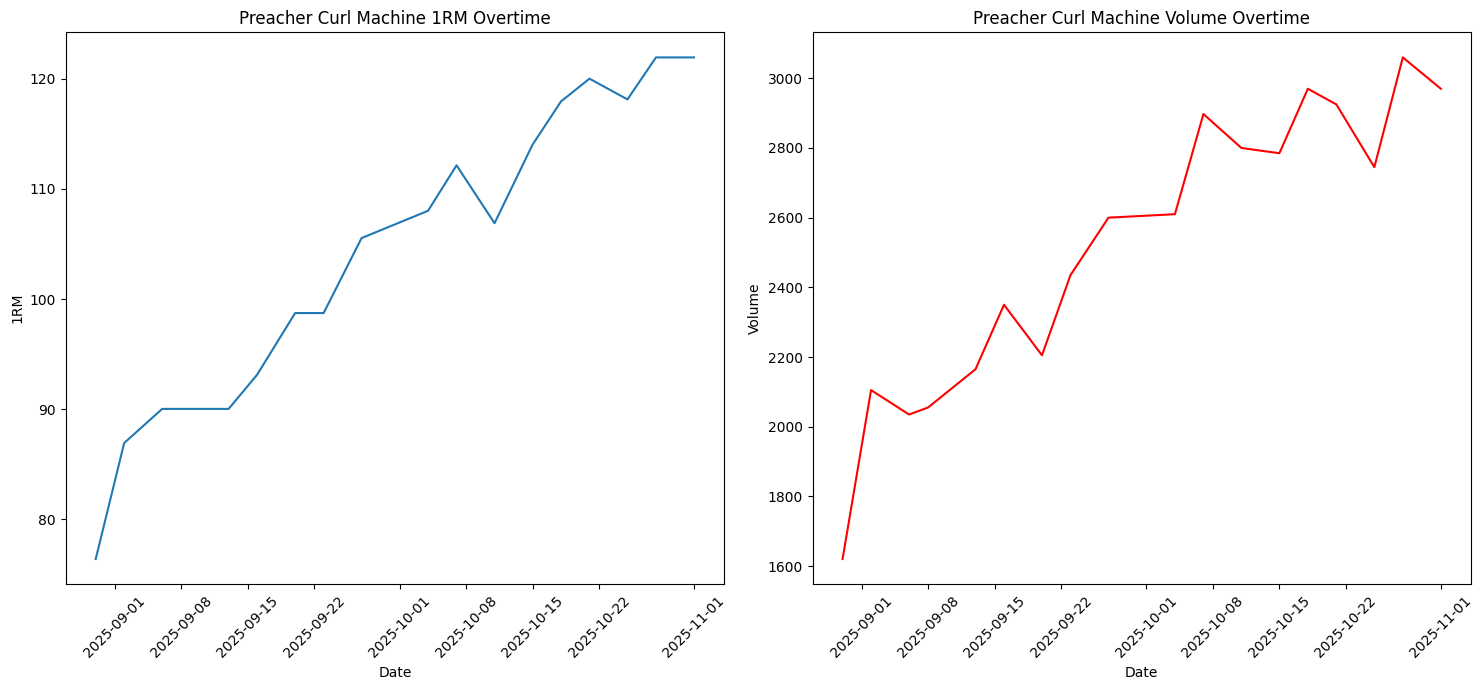

In [3]:
def plotOneRepMaxAndVol(Exercise):
    exerciseData = df[df["Exercise"] == Exercise]
    exerciseDataThree = exerciseData[exerciseData["Sets"] == 3]

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    axes[0].plot(exerciseDataThree["Date"], exerciseDataThree["1RM"])
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("1RM")
    axes[0].set_title(f"{Exercise} 1RM Overtime")
    axes[0].tick_params(axis='x', rotation=45)

    axes[1].plot(exerciseDataThree["Date"], exerciseDataThree["Total Volume"], color='red')
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Volume")
    axes[1].set_title(f"{Exercise} Volume Overtime")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
    return

exercises = df["Exercise"].unique()

print("Select an exercise:")
for i, ex in enumerate(exercises, start=1):
    print(f"{i}. {ex}")

choice = int(input("Enter the number of the exercise: "))
exercise_name = exercises[choice - 1]

display(HTML(f"""
<h2 style="margin-top: 20px;">You selected: <b>{exercise_name}</b></h2>
"""))

print("\n")

plotOneRepMaxAndVol(exercise_name)


# **Predict Future 1RM**

In [31]:
def linearRegressionPredicter(dataf, x_pass, y_pass):
  X = dataf[[x_pass]]
  y = dataf[y_pass]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = LinearRegression()
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  slope = model.coef_[0]
  intercept = model.intercept_

  print("\n")
  print("Mean Squared Error:", round(mse, 2))
  print("R-squared:", round(r2, 2))
  print("Intercept:", round(intercept, 2))
  print("Slope:", round(slope, 2))

  additonalMonths = float(input("How many months into the future would you like to predict:"))
  additonalDays = additonalMonths * 30.436875
  futureDays = dataf["Days"].max() + additonalDays

  futureValue = slope * futureDays + intercept

  return futureValue, additonalDays

def filterForExerciseMax(Exercise):
    exerciseData = df[df["Exercise"] == Exercise]
    exerciseDataThree = exerciseData[exerciseData["Sets"] == 3]
    return exerciseDataThree

exercises = df["Exercise"].unique()

print("Select an exercise:")
for i, ex in enumerate(exercises, start=1):
    print(f"{i}. {ex}")

choice = int(input("Enter the number of the exercise: "))
exercise_name = exercises[choice - 1]

filterExerciseData = filterForExerciseMax(exercise_name)


future1RM, fDays = linearRegressionPredicter(filterExerciseData, "Days", "1RM")

print(f"Predicted 1RM in {round(fDays)} days: {round(future1RM, 1)}")

Select an exercise:
1. Lat Pull Down
2. Seated Row
3. Baysian Cable Curls
4. Preacher Curl Machine
5. Rear Delt Machine
6. Cable Lateral Raises
7. Tricpe Overhead Rope
8. Tricep Rope Pushdown
9. Incline Press
10. Shoulder Press
11. Fly Machine
12. Ab Machine
Enter the number of the exercise: 11


Mean Squared Error: 125.54
R-squared: 0.76
Intercept: 110.4
Slope: 1.1
How many months into the future would you like to predict:2
Predicted 1RM in 61 days: 244.4


# **Overall 1RM and Volume PLotter**

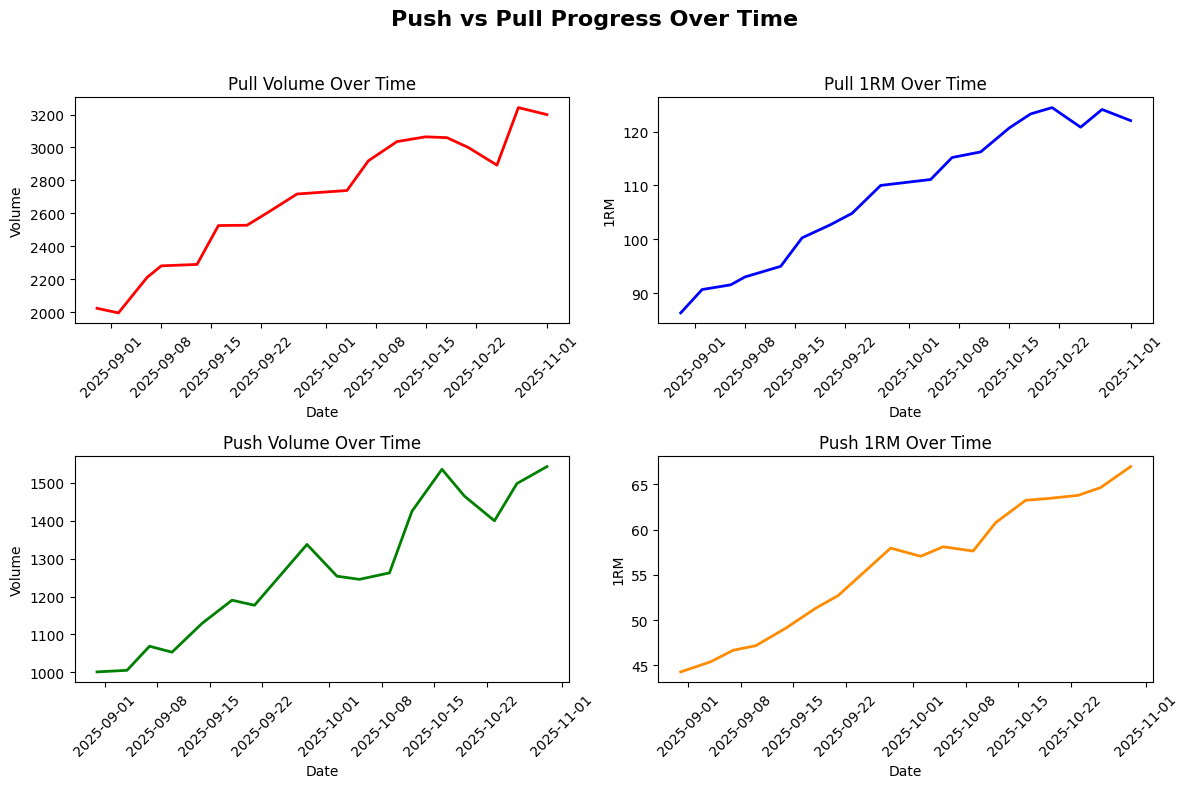

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

exerciseData = df[df["Sets"] == 3]
exerciseData = exerciseData[exerciseData["Exercise"] != "Ab Machine"]

day_exercises = (
    exerciseData.groupby(["Days", "Date"])["Exercise"]
    .apply(list)
    .reset_index(name="Exercises")
)

def detect_day_type(ex_list):
    if any("Lat Pull Down" in e for e in ex_list):
        return "Pull"
    elif any("Incline Press" in e for e in ex_list):
        return "Push"
    else:
        return "Unknown"

day_exercises["WorkoutType"] = day_exercises["Exercises"].apply(detect_day_type)

average_stats = (
    exerciseData.groupby(["Days", "Date"], as_index=False)[["1RM", "Total Volume"]]
    .mean()
)
average_stats = average_stats.merge(day_exercises[["Days", "WorkoutType"]], on="Days")

averagePullStats = average_stats[average_stats["WorkoutType"] == "Pull"]
averagePushStats = average_stats[average_stats["WorkoutType"] == "Push"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Push vs Pull Progress Over Time", fontsize=16, fontweight='bold')

# Pull Volume
axes[0, 0].plot(averagePullStats["Date"], averagePullStats["Total Volume"], color="red", linewidth=2)
axes[0, 0].set_title("Pull Volume Over Time")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Volume")
axes[0, 0].tick_params(axis='x', rotation=45)

# Pull 1RM
axes[0, 1].plot(averagePullStats["Date"], averagePullStats["1RM"], color="blue", linewidth=2)
axes[0, 1].set_title("Pull 1RM Over Time")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("1RM")
axes[0, 1].tick_params(axis='x', rotation=45)

# Push Volume
axes[1, 0].plot(averagePushStats["Date"], averagePushStats["Total Volume"], color="green", linewidth=2)
axes[1, 0].set_title("Push Volume Over Time")
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("Volume")
axes[1, 0].tick_params(axis='x', rotation=45)

# Push 1RM
axes[1, 1].plot(averagePushStats["Date"], averagePushStats["1RM"], color="darkorange", linewidth=2)
axes[1, 1].set_title("Push 1RM Over Time")
axes[1, 1].set_xlabel("Date")
axes[1, 1].set_ylabel("1RM")
axes[1, 1].tick_params(axis='x', rotation=45)

# --- Adjust layout ---
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# **Show Progression Stats**

In [6]:
def findCorrelation(Exercise):
    #Function that finds spearman correlation coefficent between 1RM and Time

    exerciseData = df[df["Exercise"] == Exercise]
    exerciseDataThree = exerciseData[exerciseData["Sets"] == 3]

    oneRepMax = exerciseDataThree["Weight"] / (1.0278 - ( 0.0278 * exerciseDataThree["Reps"]))

    corr, _ = spearmanr(exerciseDataThree["Days"], oneRepMax)
    return corr

def findPValue(Exercise):
    #Function that finds spearman correlation coefficent between 1RM and Time

    exerciseData = df[df["Exercise"] == Exercise]
    exerciseDataThree = exerciseData[exerciseData["Sets"] == 3]

    oneRepMax = exerciseDataThree["Weight"] / (1.0278 - (0.0278 * exerciseDataThree["Reps"]))

    _, pValue = spearmanr(exerciseDataThree["Days"], oneRepMax)
    return pValue


exerciseList = df["Exercise"].unique().tolist()


def avgPercentIncrease(Exercise):
    exerciseData = df[df["Exercise"] == Exercise]
    exerciseDataThree = exerciseData[exerciseData["Sets"] == 3]
    exerciseDataThree = exerciseDataThree.reset_index(drop=True)

    totalPercentIncrease = 0

    for index in range(1, len(exerciseDataThree)):
      percentInc = exerciseDataThree.loc[index, "1RM"]/exerciseDataThree.loc[index-1, "1RM"] * 100 - 100
      totalPercentIncrease += percentInc

    avgPercentInc = totalPercentIncrease / (len(exerciseDataThree) - 1)
    return avgPercentInc

def diff1RM(Exercise):
    exerciseData = df[df["Exercise"] == Exercise]
    exerciseDataThree = exerciseData[exerciseData["Sets"] == 3]
    exerciseDataThree = exerciseDataThree.reset_index(drop=True)

    min_index = exerciseDataThree["Days"].idxmin()
    max_index = exerciseDataThree["Days"].idxmax()
    min_1RM = exerciseDataThree.loc[min_index, "1RM"]
    max_1RM = exerciseDataThree.loc[max_index, "1RM"]

    return max_1RM - min_1RM




# Make new data frame with spearman correlation and P Values
corrValues = {
    'Exercise': exerciseList,
    'Corr': [findCorrelation(exercise) for exercise in exerciseList],
    'pValue': [findPValue(exercise) for exercise in exerciseList],
    'Avg % Inc': [avgPercentIncrease(exercise) for exercise in exerciseList],
    '1RM diff': [diff1RM(exercise) for exercise in exerciseList]
}

exerciseStats = pd.DataFrame(corrValues)

exerciseStats_sorted = exerciseStats.sort_values(by = 'Corr', ascending = True)
exerciseStats_sorted = exerciseStats_sorted.reset_index(drop=True)

totalDays = df["Days"].max()

weeks = round(totalDays / 7)
months = round(totalDays / 30.436875)

print("=" * 56)
print("Training Summary")
print("=" * 56)
print(f"Days:    {totalDays}")
print(f"Weeks:   {weeks}")
print(f"Months:  {months}")
print("-" * 56)


styled = exerciseStats_sorted.style.format({
    'Corr': '{:.2f}',
    'pValue': '{:.2e}',
    'Avg % Inc': '{:.2f}',
    '1RM diff': '{:.1f}'
})

display(styled)

Training Summary
Days:    63
Weeks:   9
Months:  2
--------------------------------------------------------


,Exercise,Corr,pValue,Avg % Inc,1RM diff
0,Baysian Cable Curls,0.02,9.31e-01,-0.74,-3.0
1,Tricpe Overhead Rope,0.30,2.34e-01,0.20,0.0
2,Rear Delt Machine,0.91,1.34e-07,2.14,31.6
3,Tricep Rope Pushdown,0.93,1.72e-08,2.28,14.8
4,Cable Lateral Raises,0.93,1.37e-08,4.21,5.1
5,Incline Press,0.94,1.22e-08,2.10,17.1
6,Seated Row,0.95,2.94e-09,2.24,54.0
7,Lat Pull Down,0.95,1.88e-09,2.02,50.6
8,Shoulder Press,0.95,1.13e-09,2.36,21.0
9,Fly Machine,0.96,3.13e-10,3.56,78.0


# **Body Weight Estimater**

In [30]:
# Open the spreadsheet by its name
bc = gc.open("Calories/Protien Tracker Post Injury")

# Select the sheet (tab) called "Master Data Base"
worksheet = bc.worksheet("Master")

# Convert the sheet into a pandas DataFrame
weightData = get_as_dataframe(worksheet, evaluate_formulas=True, dtype=str)

# Drop completely empty rows/columns (common in Sheets)
weightData = weightData.dropna(how="all").reset_index(drop=True)

weightData["Days"] = pd.to_numeric(weightData["Days"], errors="coerce")
weightData["Weight"] = pd.to_numeric(weightData["Weight"], errors="coerce")

weightData = weightData.dropna(subset=["Weight"])


futureWeight, futureDays = linearRegressionPredicter(weightData, "Days", "Weight")

print(f"Predicted Weight in {round(futureDays)} days: {round(futureWeight, 1)}")



Mean Squared Error: 1.0
R-squared: 0.6
Intercept: 165.01
Slope: 0.08
How many months into the future would you like to predict:3
Predicted Weight in 91 days: 179.8
